# Set up environments

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import platform
import sys
import os

# Find session type
def find_session_type():
    # windows
    if os.name == 'nt':
        path = '../input/data/'

        import japanize_matplotlib
        sns.set(font="IPAexGothic")

    elif platform.system()  == 'Darwin':
        # Mac
        path = '../input/data/'
        return 'mac'

    elif os.name == 'posix':
    # Kaggle
        if 'KAGGLE_DATA_PROXY_TOKEN' in os.environ.keys():
            print('This is kaggle session')
            return 'kaggle'

    # Google Colab
        else:
            print('This is colab session')
            # セッションの残り時間の確認
            !cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 / 60 / 60 "h)"}'
            return 'colab'
    # Mac
    # elif 'MAC' in os.environ.keys():
    #     print('This is mac session')
    #     return 'mac'
# Example usage:
if find_session_type() == 'kaggle':
    print("Running in a Kaggle notebook")
elif find_session_type() == 'mac':
    print("Running on a Mac")
    path = '../input/data/'

elif find_session_type() == 'colab':
    from google.colab import drive
    print("Running in Google Colab")
    drive.mount('/content/drive')
    os.makedirs('/content/logs', exist_ok=True)
    os.makedirs('/content/kaggle/input', exist_ok=True)
    os.makedirs('/content/kaggle/output', exist_ok=True)
else:
    print("Not running in a Kaggle notebook or Google Colab")

# if is_google_colab():
#   byu_locating_bacterial_flagellar_motors_2025_path = kagglehub.competition_download('byu-locating-bacterial-flagellar-motors-2025')

#   print('Data source import complete.')

class Config:
    def __init__(self):
        self.seed = 42
        self.debug = False
        self.epochs = 10
        self.batch_size = 32
        self.learning_rate = 1e-3
        self.weight_decay = 1e-4
        self.momentum = 0.9
        self.model_name = 'resnet18'
        self.input_size = (224, 224)
        self.num_classes = 86
        self.yolo_settings = {
            'input_size': (640, 640),
            'num_classes': 86,
            'conf_threshold': 0.5,
            'nms_threshold': 0.4,
            'iou_threshold': 0.5,
            'max_detections': 100,
            'hyperparameter_tune': {
                'epochs': 30,
                'batch_size': 4,
                'iterations': 300,
                'optimizer': 'AdamW',
                'plots': False,
                'save': False,
                'val': False,
                'search_space': {
                    'lr0': (1e-4, 1e-2),
                    'momentum': (0.8, 0.95),
                    'weight_decay': (0.0, 0.0005),
                    'fl_gamma': (0.0, 2.0),
                    'hsv_h': (0.0, 0.1),
                    'hsv_s': (0.0, 0.9),
                    'hsv_v': (0.0, 0.9),
                    'translate': (0.0, 0.9),
                    'mixup': (0.0, 0.4),
                    'copy_paste': (0.0, 0.0),
                    'shear': (0.0, 0.0),
                    'hsv_h': (0.0, 0.1),
                    'hsv_s': (0.0, 0.9),
                    'hsv_v': (0.0, 0.9),
                    'translate': (0.0, 0.9),
                    'flipud': (0.0, 0.5),
                    'fliplr': (0.0, 0.5),
                    'scale': (0.1, 0.9)
                    }
            },
            'model_setting': {
                'hsv_h': 0.0,
                'hsv_s': 0.7,
                'hsv_v': 0.6,
                'translate': 0.3,
                'flipud': 0.2,
                'fliplr': 0.5,
                'scale': 0.7
            },
            'search_space': {
                'lr0': (1e-4, 1e-2)
            },
        }

config = Config()

This is colab session
0.0227294days (0.545506h)
This is colab session
0.0227307days (0.545536h)
This is colab session
0.0227318days (0.545564h)
Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre

In [ ]:
# Important settings

DEBUG_MODE = False
EPOCH_SIZE = 100
PATCH_SIZE = 640
IMAGE_SIZE = 960

# Determine optimal number of DataLoader workers
cpu_count = os.cpu_count()
if find_session_type() == 'kaggle':
    NUM_WORKERS = min(4, cpu_count)  # Kaggle has limit
elif find_session_type() == 'colab':
    NUM_WORKERS = min(2, cpu_count)  # Colab is often limited
else:
    NUM_WORKERS = max(2, cpu_count // 2)  # Local: use half of CPUs

print(f"Number of DataLoader workers set to {NUM_WORKERS}")

yolo_pretrained_weights = "yolov8n.pt"
model_name = "yolov8n-006-raw"
model_fol_path = os.path.join("/content/drive/MyDrive/kaggle/BYU-motor-detection/models", model_name)
train_data_path = "/content/drive/MyDrive/kaggle/BYU-motor-detection/datas/yolo_dataset_raw.zip"
print(os.path.exists(train_data_path))
# os.makedirs(model_fol_path, exist_ok=True)

This is colab session
0.0256968days (0.616722h)
This is colab session
0.0256979days (0.61675h)
Number of DataLoader workers set to 2
True


## 1) Library and Dependencies

In [ ]:
if find_session_type() == 'kaggle':
    !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics
    !rm -rf ./packages
if find_session_type() == 'colab':
    # Unzip archive.tar.gz
    !tar --warning=none -xvf /content/drive/MyDrive/kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics  > /content/logs/pipinstall_log.txt
    !rm -rf ./packages

    # Unzip Dataset folder
    if DEBUG_MODE:
        !unzip -q /content/drive/MyDrive/kaggle/BYU-motor-detection/datas/byu-locating-bacterial-flagellar-motors-2025-forcoding -d /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025  > /content/logs/unzip_log.txt
    else:
        !unzip -q $train_data_path -d /content/kaggle/  > /content/logs/unzip_log.txt
else:
    !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics
    !rm -rf ./packages

This is colab session
0.0232763days (0.558631h)
This is colab session
0.0232774days (0.558658h)
./packages/
./packages/pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl
./packages/numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/psutil-6.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/charset_normalizer-3.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl
./packages/torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl
./packages/matplotlib-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/tqdm-4.67.1-py3-none-any.whl
./packages/networkx-3.4.2-p

In [ ]:
# Libraries
from PIL import Image, ImageDraw
import random
import seaborn as sns
from matplotlib.patches import Rectangle
import yaml
import json
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
import threading
import time
from contextlib import nullcontext
from concurrent.futures import ThreadPoolExecutor
import math

if not find_session_type() == 'mac':
    from ultralytics import YOLO
    import plotly.express as px

# Directries setting
if find_session_type() == 'kaggle':
    WORKING_DIR = "/kaggle/working"
elif find_session_type() == 'colab':
    WORKING_DIR = "/content/kaggle/working"
elif find_session_type() == 'mac':
    WORKING_DIR = "../working"
else:
    WORKING_DIR = "/kaggle/working"


yolo_dataset_dir = os.path.join(WORKING_DIR, "yolo_dataset")
yolo_weights_dir = os.path.join(WORKING_DIR, "yolo_weights")
yolo_images_train = os.path.join(yolo_dataset_dir, "images", "train")
yolo_images_val = os.path.join(yolo_dataset_dir, "images", "val")
yolo_labels_train = os.path.join(yolo_dataset_dir, "labels", "train")
yolo_labels_val = os.path.join(yolo_dataset_dir, "labels", "val")

# Set paths for the preprocessed YOLO training images and labels.
images_train_dir = os.path.join(yolo_dataset_dir, "images", "train")
labels_train_dir = os.path.join(yolo_dataset_dir, "labels", "train")

dir_info = {
    'yolo_dataset_dir': yolo_dataset_dir,
    'yolo_images_train': yolo_images_train,
    'yolo_labels_train': yolo_labels_train,
    'yolo_images_val': yolo_images_val,
    'yolo_labels_val': yolo_labels_val,
    'yolo_weights_dir': yolo_weights_dir
}

# Create the weights directory if it does not exist
os.makedirs(yolo_weights_dir, exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

This is colab session
0.0255964days (0.614314h)
This is colab session
0.0255976days (0.614342h)
This is colab session
0.0255987days (0.614369h)


## 1.1) Global Constants and Environment Setup

We define paths, create necessary directories, set up the computing device (GPU if available), and fix random seeds for reproducibility.


In [ ]:
# Define global constants for dataset directories
if find_session_type() == 'kaggle':
    ROOT_DIR = '/kaggle/'
elif find_session_type() == 'colab':
    ROOT_DIR = '/content/kaggle/'
else:
    ROOT_DIR = '/kaggle/'
DATA_DIR = os.path.join(ROOT_DIR, 'input/byu-locating-bacterial-flagellar-motors-2025')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
OUTPUT_DIR = './'
MODEL_DIR = './models'

# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Set device: Use GPU if available; otherwise, fall back to CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None

    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self

    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        # print(f"[PROFILE] {self.name}: {elapsed:.3f}s")


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True

    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")

    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4  # Reduce batch size for CPU

config.batch_size = BATCH_SIZE
config.yolo_settings['hyperparameter_tune']['batch'] = BATCH_SIZE

This is colab session
0.0257796days (0.618711h)
This is colab session
0.0257808days (0.618739h)
Using device: cuda
Using GPU: Tesla T4 with 15.83 GB memory
Dynamic batch size set to 32 based on 15.83GB free memory


# 3) **YOLO**

## 3.1) Data Preprocessing for YOLO Dataset Preparation

In this section, we:

- **Load Motor Annotations:** Read the tomogram and motor location annotations.
- **Slice Extraction:** For each motor, extract 2D slices (with a configurable range above and below the motor slice).
- **Image Normalization:** Normalize each slice using percentile-based contrast enhancement.
- **Dataset Organization:** Save the normalized images and generate YOLO-format bounding box annotations.
- **Train/Validation Split:** Split the data by tomogram to avoid any overlap between training and validation sets.
- **Configuration File Generation:** Create a `dataset.yaml` file for YOLO training.


## 3.1) Visualization of Preprocessed Data

In this final section, we validate our preprocessing steps by visualizing random training samples along with their YOLO annotations.
This allows us to inspect the bounding box placements and verify that the data is ready for model training.


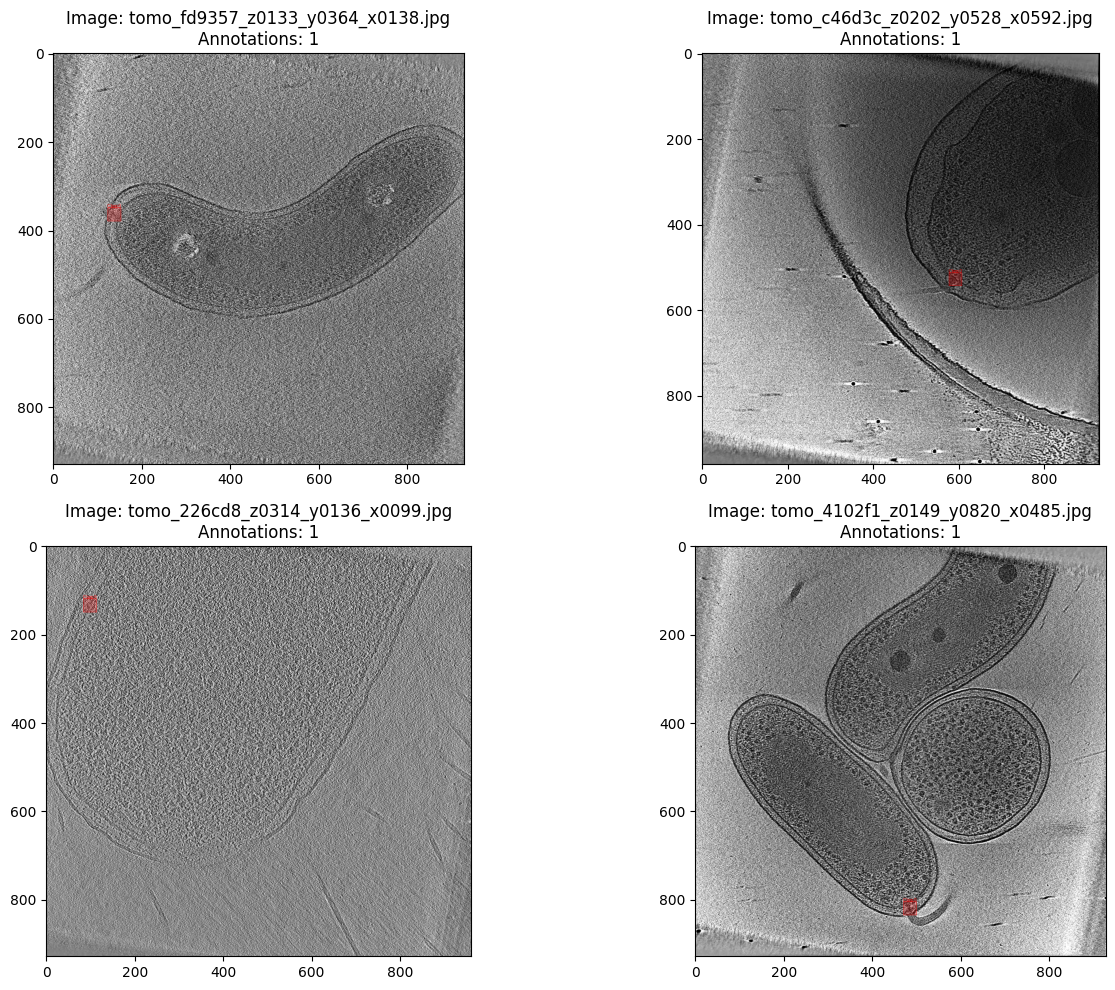

Displayed 4 random images with YOLO annotations


In [ ]:
# %%
def visualize_random_training_samples(num_samples=4, dir_info:dict=None):
    """
    Visualize random training samples with YOLO annotations.

    Args:
        num_samples (int): Number of random images to display.
        dir_info (dict): Dictionary containing directory paths for images and labels.
            {"data_path": "../input/data",
            "train_dir": "../input/data/train",
            "yolo_dataset_dir": "path/to/yolo_dataset",
            "yolo_images_train": "path/to/yolo_images_train",
            "yolo_labels_train": "path/to/yolo_labels_train",
            "yolo_images_val": "path/to/yolo_images_val",
            "yolo_labels_val": "path/to/yolo_labels_val"}
    """
    # Get all image files from the train directory (support multiple image extensions)
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files.extend(glob.glob(os.path.join(dir_info['yolo_images_train'], "**", ext), recursive=True))

    if len(image_files) == 0:
        print("No image files found in the train directory!")
        return

    num_samples = min(num_samples, len(image_files))
    random_images = random.sample(image_files, num_samples)

    # Create subplots for visualization
    rows = int(np.ceil(num_samples / 2))
    cols = min(num_samples, 2)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))

    if num_samples == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, img_path in enumerate(random_images):
        try:
            # Determine corresponding label file (YOLO format)
            relative_path = os.path.relpath(img_path, dir_info['yolo_images_train'])
            label_path = os.path.join(dir_info['yolo_labels_train'], os.path.splitext(relative_path)[0] + '.txt')

            # Load and normalize image for display
            img = Image.open(img_path)
            img_width, img_height = img.size
            img_array = np.array(img)
            p2 = np.percentile(img_array, 2)
            p98 = np.percentile(img_array, 98)
            normalized = np.clip(img_array, p2, p98)
            normalized = 255 * (normalized - p2) / (p98 - p2)
            img_normalized = Image.fromarray(np.uint8(normalized))

            # Convert to RGB for annotation drawing
            img_rgb = img_normalized.convert('RGB')
            overlay = Image.new('RGBA', img_rgb.size, (0, 0, 0, 0))
            draw = ImageDraw.Draw(overlay)

            # Load YOLO annotations if available
            annotations = []
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        # YOLO format: class x_center y_center width height (normalized values)
                        values = line.strip().split()
                        class_id = int(values[0])
                        x_center = float(values[1]) * img_width
                        y_center = float(values[2]) * img_height
                        width = float(values[3]) * img_width
                        height = float(values[4]) * img_height
                        annotations.append({
                            'class_id': class_id,
                            'x_center': x_center,
                            'y_center': y_center,
                            'width': width,
                            'height': height
                        })

            # Draw annotations on the overlay
            for ann in annotations:
                x_center = ann['x_center']
                y_center = ann['y_center']
                width = ann['width']
                height = ann['height']
                x1 = max(0, int(x_center - width/2))
                y1 = max(0, int(y_center - height/2))
                x2 = min(img_width, int(x_center + width/2))
                y2 = min(img_height, int(y_center + height/2))
                draw.rectangle([x1, y1, x2, y2], fill=(255, 0, 0, 64), outline=(255, 0, 0, 200))
                draw.text((x1, y1-10), f"Class {ann['class_id']}", fill=(255, 0, 0, 255))

            # Indicate if no annotations were found
            if not annotations:
                draw.text((10, 10), "No annotations found", fill=(255, 0, 0, 255))

            # Composite overlay and display image
            img_rgb = Image.alpha_composite(img_rgb.convert('RGBA'), overlay).convert('RGB')
            axes[i].imshow(np.array(img_rgb))
            img_name = os.path.basename(img_path)
            axes[i].set_title(f"Image: {img_name}\nAnnotations: {len(annotations)}")
            axes[i].axis('on')

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading image: {os.path.basename(img_path)}",
                         horizontalalignment='center', verticalalignment='center')
            axes[i].axis('off')

    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Displayed {num_samples} random images with YOLO annotations")

# Define directory information for YOLO dataset

# Run visualization of random training samples
visualize_random_training_samples(4, dir_info)

## 3.3) YOLOv8 Training Pipeline for Flagellar Motor Detection

This notebook implements a full YOLOv8 training pipeline for detecting bacterial flagellar motors in tomographic slices.

Overview:

- Dataset Configuration: Sets up and validates the YOLO-format dataset YAML file.
Model Initialization: Loads pre-trained YOLOv8 weights for transfer learning.
- Training Process: Fine tunes the model with early stopping and periodic checkpoints.
Loss Visualization: Plots training and validation DFL loss curves to monitor progress.
- Performance Evaluation: Tests the trained model on random validation samples.
- Model Export: Saves the trained weights for later use.

Let's begin by importing the necessary libraries and setting up reproducibility.

## 3.4) Dataset Configuration and YAML Fixing

The function below reads the original YAML file and fixes the paths to match the actual Kaggle directory structure.

- **fix_yaml_paths:** Reads the dataset YAML file, updates the 'path' entry, and writes a fixed version to the working directory.

In [ ]:
def fix_yaml_paths(yaml_path):
    """
    Fix the paths in the YAML file to match the actual Kaggle directories.

    Args:
        yaml_path (str): Path to the original dataset YAML file.

    Returns:
        str: Path to the fixed YAML file.
    """
    print(f"Fixing YAML paths in {yaml_path}")
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    if 'path' in yaml_data:
        yaml_data['path'] = yolo_dataset_dir

    fixed_yaml_path = os.path.join(WORKING_DIR, "fixed_dataset.yaml")
    with open(fixed_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)

    print(f"Created fixed YAML at {fixed_yaml_path} with path: {yaml_data.get('path')}")
    return fixed_yaml_path

def plot_dfl_loss_curve(run_dir):
    """
    Plot the DFL loss curves for training and validation, marking the best model.

    Args:
        run_dir (str): Directory where the training results are stored.
    """
    results_csv = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(results_csv):
        print(f"Results file not found at {results_csv}")
        return

    results_df = pd.read_csv(results_csv)
    train_dfl_col = [col for col in results_df.columns if 'train/dfl_loss' in col]
    val_dfl_col = [col for col in results_df.columns if 'val/dfl_loss' in col]

    if not train_dfl_col or not val_dfl_col:
        print("DFL loss columns not found in results CSV")
        print(f"Available columns: {results_df.columns.tolist()}")
        return

    train_dfl_col = train_dfl_col[0]
    val_dfl_col = val_dfl_col[0]

    best_epoch = results_df[val_dfl_col].idxmin()
    best_val_loss = results_df.loc[best_epoch, val_dfl_col]

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['epoch'], results_df[train_dfl_col], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df[val_dfl_col], label='Validation DFL Loss')
    plt.axvline(x=results_df.loc[best_epoch, 'epoch'], color='r', linestyle='--',
                label=f'Best Model (Epoch {int(results_df.loc[best_epoch, "epoch"])}, Val Loss: {best_val_loss:.4f})')
    plt.xlabel('Epoch')
    plt.ylabel('DFL Loss')
    plt.title('Training and Validation DFL Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plot_path = os.path.join(run_dir, 'dfl_loss_curve.png')
    plt.savefig(plot_path)
    plt.savefig(os.path.join(WORKING_DIR, 'dfl_loss_curve.png'))

    print(f"Loss curve saved to {plot_path}")
    plt.close()

    return best_epoch, best_val_loss

In [ ]:
def train_yolo_model(yaml_path, pretrained_weights_path, dir_info, epochs=30, batch_size=16, img_size=IMAGE_SIZE):
    """
    Train a YOLO model on the prepared dataset.

    Args:
        yaml_path (str): Path to the dataset YAML file.
        pretrained_weights_path (str): Path to pre-downloaded weights file.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        img_size (int): Image size for training.
    """
    print(f"Loading pre-trained weights from: {pretrained_weights_path}")
    model = YOLO(pretrained_weights_path)
    tune_params = config.yolo_settings['hyperparameter_tune']
    tune_params['data'] = yaml_path
    results = model.tune(**tune_params)
    print(f"Training YOLO model with parameters: {tune_params}")

    # results = model.train(
    #     data=yaml_path,
    #     epochs=epochs,
    #     batch=batch_size,
    #     imgsz=img_size,
    #     project=dir_info['yolo_weights_dir'],
    #     name='motor_detector',
    #     exist_ok=True,
    #     patience=5,
    #     save_period=5,
    #     val=True,
    #     verbose=True
    # )

    run_dir = os.path.join(dir_info['yolo_weights_dir'], 'motor_detector')
    best_epoch_info = plot_dfl_loss_curve(run_dir)
    if best_epoch_info:
        best_epoch, best_val_loss = best_epoch_info
        print(f"\nBest model found at epoch {best_epoch} with validation DFL loss: {best_val_loss:.4f}")

    return model, results

def predict_on_samples(model, num_samples=4):
    """
    Run predictions on random validation samples and display results.

    Args:
        model: Trained YOLO model.
        num_samples (int): Number of random samples to test.
    """
    val_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    if not os.path.exists(val_dir):
        print(f"Validation directory not found at {val_dir}")
        val_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
        print(f"Using train directory for predictions instead: {val_dir}")

    if not os.path.exists(val_dir):
        print("No images directory found for predictions")
        return

    val_images = os.listdir(val_dir)
    if len(val_images) == 0:
        print("No images found for prediction")
        return

    num_samples = min(num_samples, len(val_images))
    samples = random.sample(val_images, num_samples)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for i, img_file in enumerate(samples):
        if i >= len(axes):
            break

        img_path = os.path.join(val_dir, img_file)
        results = model.predict(img_path, conf=0.25)[0]
        img = Image.open(img_path)
        axes[i].imshow(np.array(img), cmap='gray')

        # Draw ground truth box if available (extracted from filename)
        try:
            parts = img_file.split('_')
            y_part = [p for p in parts if p.startswith('y')]
            x_part = [p for p in parts if p.startswith('x')]
            if y_part and x_part:
                y_gt = int(y_part[0][1:])
                x_gt = int(x_part[0][1:].split('.')[0])
                box_size = 24
                rect_gt = Rectangle((x_gt - box_size//2, y_gt - box_size//2), box_size, box_size,
                                      linewidth=1, edgecolor='g', facecolor='none')
                axes[i].add_patch(rect_gt)
        except:
            pass

        if len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()
            for box, conf in zip(boxes, confs):
                x1, y1, x2, y2 = box
                rect_pred = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect_pred)
                axes[i].text(x1, y1-5, f'{conf:.2f}', color='red')

        axes[i].set_title(f"Image: {img_file}\nGT (green) vs Pred (red)")

    plt.tight_layout()
    plt.savefig(os.path.join(WORKING_DIR, 'predictions.png'))
    plt.show()

def prepare_dataset():
    """
    Check if the dataset exists and create/fix a proper YAML file for training.

    Returns:
        str: Path to the YAML file to use for training.
    """
    train_images_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
    val_images_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    train_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'train')
    val_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'val')

    print(f"Directory status:")
    print(f"- Train images exists: {os.path.exists(train_images_dir)}")
    print(f"- Val images exists: {os.path.exists(val_images_dir)}")
    print(f"- Train labels exists: {os.path.exists(train_labels_dir)}")
    print(f"- Val labels exists: {os.path.exists(val_labels_dir)}")

    original_yaml_path = os.path.join(yolo_dataset_dir, 'dataset.yaml')
    if os.path.exists(original_yaml_path):
        print(f"Found original dataset.yaml at {original_yaml_path}")
        return fix_yaml_paths(original_yaml_path)
    else:
        print("Original dataset.yaml not found, creating a new one")
        yaml_data = {
            'path': yolo_dataset_dir,
            'train': 'images/train',
            'val': 'images/train' if not os.path.exists(val_images_dir) else 'images/val',
            'names': {0: 'motor'}
        }
        new_yaml_path = os.path.join(WORKING_DIR, 'dataset.yaml')
        with open(new_yaml_path, 'w') as f:
            yaml.dump(yaml_data, f)
        print(f"Created new YAML at {new_yaml_path}")
        return new_yaml_path

def distance_metric(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    thresh_ratio: float,
    min_radius: float,
):
    coordinate_cols = ['Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    label_tensor = solution[coordinate_cols].values.reshape(len(solution), -1, len(coordinate_cols))
    predicted_tensor = submission[coordinate_cols].values.reshape(len(submission), -1, len(coordinate_cols))
    # Find the minimum euclidean distances between the true and predicted points
    solution['distance'] = np.linalg.norm(label_tensor - predicted_tensor, axis=2).min(axis=1)
    # Convert thresholds from angstroms to voxels
    solution['thresholds'] = solution['Voxel spacing'].apply(lambda x: (min_radius * thresh_ratio) / x)
    solution['predictions'] = submission['Has motor'].values
    solution.loc[(solution['distance'] > solution['thresholds']) & (solution['Has motor'] == 1) & (submission['Has motor'] == 1), 'predictions'] = 0
    return solution['predictions'].values

def score(solution:pd.DataFrame, submission:pd.DataFrame, min_radius:float=1000, beta:float=2) -> float:
    """
    Parameters:
    solution (pd.DataFrame): DataFrame containing ground truth motor positions.
    submission (pd.DataFrame): DataFrame containing predicted motor positions.

    Returns:
    float: FBeta score.

    Example
    --------
    >>> solution = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [-1, 250, 100, 200],
    ...     'Motor axis 1': [-1, 250, 100, 200],
    ...     'Motor axis 2': [-1, 250, 100, 200],
    ...     'Voxel spacing': [10, 10, 10, 10],
    ...     'Has motor': [0, 1, 1, 1]
    ... })
    >>> submission = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [100, 251, 600, -1],
    ...     'Motor axis 1': [100, 251, 600, -1],
    ...     'Motor axis 2': [100, 251, 600, -1]
    ... })
    >>> score(solution, submission, 1000, 2)
    0.3571428571428571
    """

    solution = solution.sort_values('tomo_id').reset_index(drop=True)
    submission = submission.sort_values('tomo_id').reset_index(drop=True)

    filename_equiv_array = solution['tomo_id'].eq(submission['tomo_id'], fill_value=0).values

    if np.sum(filename_equiv_array) != len(solution['tomo_id']):
        raise ValueError('Submitted tomo_id values do not match the sample_submission file')

    submission['Has motor'] = 1
    # If any columns are missing an axis, it's marked with no motor
    select = (submission[['Motor axis 0', 'Motor axis 1', 'Motor axis 2']] == -1).any(axis='columns')
    submission.loc[select, 'Has motor'] = 0

    cols = ['Has motor', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    assert all(col in submission.columns for col in cols)

    # Calculate a label of 0 or 1 using the 'has motor', and 'motor axis' values
    predictions = distance_metric(
        solution,
        submission,
        thresh_ratio=1.0,
        min_radius=min_radius,
    )

    return fbeta_score(solution['Has motor'].values, predictions, beta=beta)

def evaluate_model(best_model_path, val_image_paths):
    test_dir = os.path.join(data_path, "test")
    test_images_dir = os.path.join(test_dir, "tomo_00e047")
    test_images = sorted(os.listdir(test_images_dir))
    test_images = [img for img in test_images if img.endswith('.jpg')]
    tomo_ids = [img.split('_')[1] for img in test_images]
    tomo_ids = list(set(tomo_ids))
    tomo_ids = [f'tomo_{tomo_id}' for tomo_id in tomo_ids]

    # Create a DataFrame to store the test results
    test_results = pd.DataFrame(columns=['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2'])

    model = YOLO(best_model_path)

    # YOLOで推論
    results = model(val_image_paths)


## 3.8) Dataset YAML Preparation and Main Training Execution

Before training, we check if the dataset directories exist and either fix or create a new YAML file.

- **prepare_dataset:** Checks for directories and a YAML file, fixes the paths if necessary, or creates a new YAML file.

Finally, the **main** function runs the complete training process and then tests the model on sample images.

Starting YOLO training process...
Directory status:
- Train images exists: True
- Val images exists: True
- Train labels exists: True
- Val labels exists: True
Found original dataset.yaml at /content/kaggle/working/yolo_dataset/dataset.yaml
Fixing YAML paths in /content/kaggle/working/yolo_dataset/dataset.yaml
Created fixed YAML at /content/kaggle/working/fixed_dataset.yaml with path: /content/kaggle/working/yolo_dataset
Using YAML file: /content/kaggle/working/fixed_dataset.yaml
YAML contents:
names:
  0: motor
path: /content/kaggle/working/yolo_dataset
train: images/train
val: images/val


Starting YOLO training...
Loading pre-trained weights from: yolov8n.pt


100%|██████████| 6.25M/6.25M [00:00<00:00, 170MB/s]

New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/kaggle/working/fixed_dataset.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=960, save=True, save_period=5, cache=False, device=None, workers=8, project=/content/kaggle/working/yolo_weights, name=motor_detector, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, r

100%|██████████| 755k/755k [00:00<00:00, 43.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 191MB/s]


AMP: checks passed ✅


train: Scanning /content/kaggle/working/yolo_dataset/labels/train... 2664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2664/2664 [00:01<00:00, 1607.35it/s]

train: New cache created: /content/kaggle/working/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/kaggle/working/yolo_dataset/labels/val... 633 images, 0 backgrounds, 0 corrupt: 100%|██████████| 633/633 [00:00<00:00, 1487.54it/s]

val: New cache created: /content/kaggle/working/yolo_dataset/labels/val.cache


Plotting labels to /content/kaggle/working/yolo_weights/motor_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to /content/kaggle/working/yolo_weights/motor_detector
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.854G      3.119      11.96      1.715          9        960: 100%|██████████| 84/84 [00:51<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

                   all        633        633   1.58e-05    0.00474   3.08e-05   8.25e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.07G      2.286      4.015      1.289         12        960: 100%|██████████| 84/84 [00:44<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

                   all        633        633       0.28      0.408      0.182      0.054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.07G      2.084      2.453      1.211          7        960: 100%|██████████| 84/84 [00:44<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        633        633      0.584      0.508      0.521      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.07G      1.938      1.895      1.155          8        960: 100%|██████████| 84/84 [00:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        633        633      0.235      0.142     0.0997      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.07G      1.879      1.643      1.148          9        960: 100%|██████████| 84/84 [00:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

                   all        633        633      0.777       0.64       0.73      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.06G      1.769      1.447      1.111         11        960: 100%|██████████| 84/84 [00:44<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        633        633      0.744      0.708      0.733      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.06G      1.686      1.351      1.074         12        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

                   all        633        633      0.864      0.784       0.84      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.06G      1.688      1.254      1.085         16        960: 100%|██████████| 84/84 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        633        633      0.718       0.69      0.731       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.07G      1.606       1.16      1.052          8        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

                   all        633        633       0.78      0.726      0.764      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.06G      1.564      1.122      1.036          9        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        633        633      0.812      0.821      0.856      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.06G      1.498      1.095      1.009         13        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

                   all        633        633      0.755      0.722      0.757      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.06G      1.491      1.055      1.008         11        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

                   all        633        633      0.846      0.814      0.877      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.06G      1.443     0.9921      1.003          7        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        633        633      0.842       0.78      0.858      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.06G      1.439     0.9607     0.9909         10        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

                   all        633        633       0.84      0.773      0.844      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.06G      1.385     0.9613     0.9754          9        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

                   all        633        633      0.773      0.686      0.709      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.07G      1.378     0.9307     0.9816         10        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

                   all        633        633      0.851      0.829      0.884       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.06G      1.334     0.9257     0.9649         12        960: 100%|██████████| 84/84 [00:45<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

                   all        633        633      0.836      0.832      0.875      0.456
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 12, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



17 epochs completed in 0.246 hours.
Optimizer stripped from /content/kaggle/working/yolo_weights/motor_detector/weights/last.pt, 6.3MB
Optimizer stripped from /content/kaggle/working/yolo_weights/motor_detector/weights/best.pt, 6.3MB

Validating /content/kaggle/working/yolo_weights/motor_detector/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


                   all        633        633      0.846      0.813      0.875      0.475
Speed: 0.4ms preprocess, 4.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/kaggle/working/yolo_weights/motor_detector
Loss curve saved to /content/kaggle/working/yolo_weights/motor_detector/dfl_loss_curve.png

Best model found at epoch 11 with validation DFL loss: 1.0542

Training complete!

Running predictions on sample images...

image 1/1 /content/kaggle/working/yolo_dataset/images/val/tomo_9cd09e_z0119_y0817_x0772.jpg: 960x928 1 motor, 229.9ms
Speed: 3.4ms preprocess, 229.9ms inference, 1.5ms postprocess per image at shape (1, 3, 960, 928)

image 1/1 /content/kaggle/working/yolo_dataset/images/val/tomo_1af88d_z0025_y0306_x0619.jpg: 960x928 1 motor, 7.0ms
Speed: 5.3ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 928)

image 1/1 /content/kaggle/working/yolo_dataset/images/val/tomo_9cd09e_z0122_y0817_x0772.jpg: 960x928 2 motors, 6.9

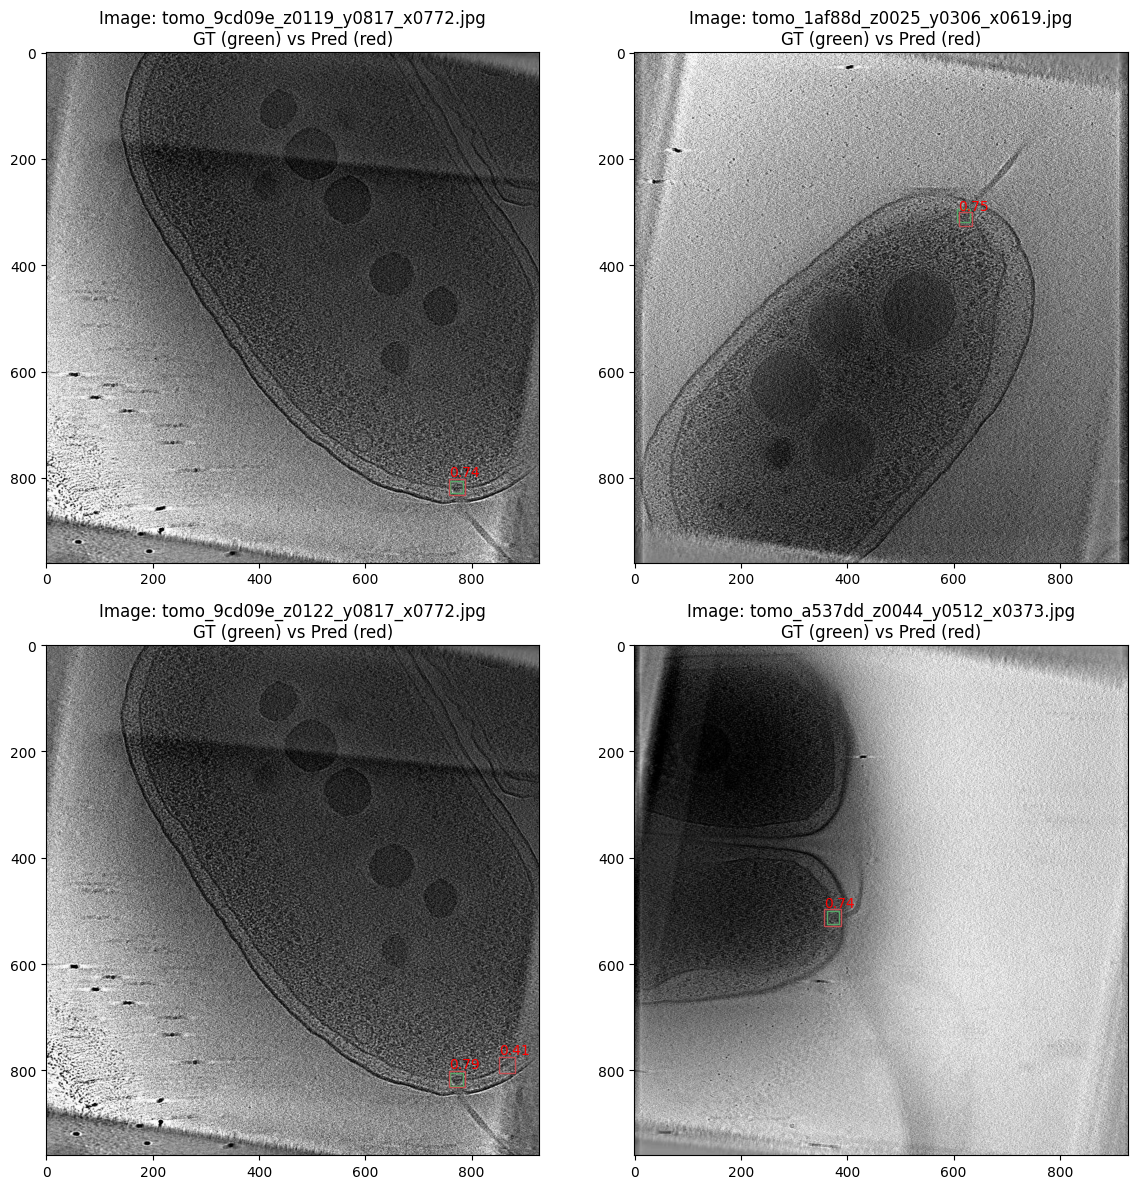

Model weights saved to /content/kaggle/working/yolo_weights
Training and predictions completed.
Saving to /content/drive/MyDrive/kaggle/BYU-motor-detection/models/yolov8n-006-raw


In [ ]:
def main():
    print("Starting YOLO training process...")
    yaml_path = prepare_dataset()
    print(f"Using YAML file: {yaml_path}")
    with open(yaml_path, 'r') as f:
        print(f"YAML contents:\n{f.read()}")

    print("\nStarting YOLO training...")
    model, results = train_yolo_model(
        yaml_path,
        pretrained_weights_path=yolo_pretrained_weights,
        dir_info=dir_info,
        epochs=EPOCH_SIZE,  # For demonstration, using 30 epochs
        batch_size=BATCH_SIZE
        #TODO: find best epochs.
    )

    print("\nTraining complete!")
    print("\nRunning predictions on sample images...")
    predict_on_samples(model, num_samples=4)

if __name__ == "__main__":
    main()
    print(f'Model weights saved to {dir_info["yolo_weights_dir"]}')
    print("Training and predictions completed.")
    print(f'Saving to {model_fol_path}')
    model_fol = os.path.join(WORKING_DIR, 'yolo_weights', 'motor-detector')
    !cp -r /content/kaggle/working/ $model_fol_path

In [ ]:
print(f'Saving to {model_fol_path}')
!cp -r /content/kaggle/working/ $model_fol_path
dataset_fol = os.path.join(model_fol_path, 'yolo_dataset')
!rm -r $dataset_fol

Saving to /content/drive/MyDrive/kaggle/BYU-motor-detection/models/yolov8n-004-blu-fli
rm: cannot remove '/content/drive/MyDrive/kaggle/BYU-motor-detection/models/yolov8n-004-blu-fli/yolo_dataset': No such file or directory


In [ ]:
!rm -r /content/drive/MyDrive/kaggle/working/yolo11n_test/working/yolo_dataset